<a href="https://colab.research.google.com/github/SAMashiyane/Residual_CNN_Explanation/blob/main/Inverted_Residual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inverted Residual**

The difference between residual block
and inverted residual.They expand features with the first conv instead of reducing them. The following image should make this clear
show lower image :

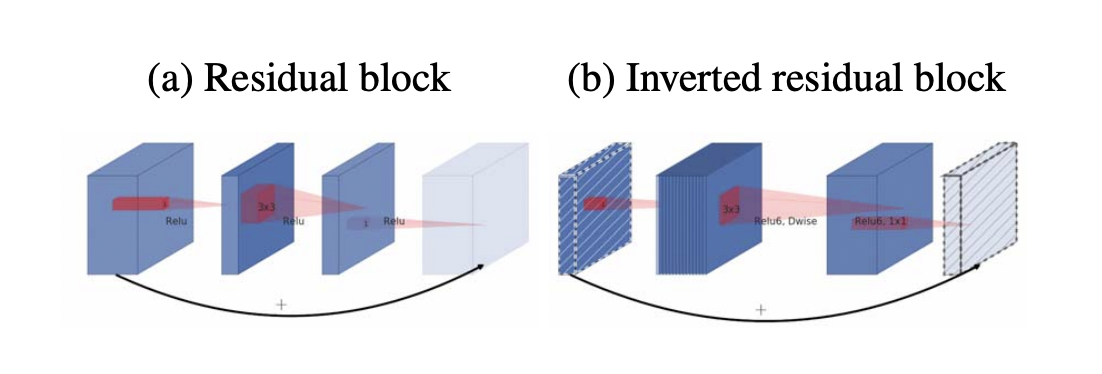

Instead of going----->  : **wide -> narrow -> wide** 

⏬ in normal bottleneck block, they do the opposite---> **narrow -> wide -> narrow**

# **reference**:
[MobileNetV2: Inverted Residuals and Linear Bottlenecks
](https://arxiv.org/abs/1801.04381)

In [1]:
!nvidia-smi 

Thu Mar 31 12:51:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import glob
import cv2
import shutil
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from torchvision.models import resnet18, resnet34 ,resnet50
import os
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
use_gpu = torch.cuda.is_available()

use_gpu

True

In [3]:
from typing import Optional
from functools import partial
class ConvNormAct(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        kernel_size: int,
        norm: nn.Module = nn.BatchNorm2d,
        act: nn.Module = nn.ReLU,
        **kwargs
    ):

        super().__init__(
            nn.Conv2d(
                in_features,
                out_features,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
            ),
            norm(out_features),
            act(),
        )
# --------------------------------------------------------------------
Conv1X1BnReLU = partial(ConvNormAct, kernel_size=1)
Conv3X3BnReLU = partial(ConvNormAct, kernel_size=3)
# ---------------------------------------------------------------------
class ResidualAdd(nn.Module):
    def __init__(self, block: nn.Module, shortcut: Optional[nn.Module] = None):
        super().__init__()
        self.block = block
        self.shortcut = shortcut
        
    def forward(self,x):
        res = x
        x = self.block(x)
        if self.shortcut:
            res = self.shortcut(res)
        x += res
        return x
# ----------------------------------------------------------------------
# class BottleNeck(nn.Sequential):
#     def __init__(self, in_features: int, out_features: int, reduction: int = 4):
#         reduced_features = out_features // reduction
#         super().__init__(
#             nn.Sequential(
#                 ResidualAdd(
#                     nn.Sequential(
#                         # wide -> narrow
#                         Conv1X1BnReLU(in_features, reduced_features),
#                         # narrow -> narrow
#                         Conv3X3BnReLU(reduced_features, reduced_features),
#                         # narrow -> wide
#                         Conv1X1BnReLU(reduced_features, out_features, act=nn.Identity),
#                     ),
#                     shortcut=Conv1X1BnReLU(in_features, out_features)
#                     if in_features != out_features
#                     else None,
#                 ),
#                 nn.ReLU(),
#             )
#         )
# ---------------------------------------------------------------------
class InvertedResidual(nn.Sequential):
    def __init__(self, in_features: int, out_features: int, expansion: int = 4):
        expanded_features = in_features * expansion
        super().__init__(
            nn.Sequential(
                ResidualAdd(
                    nn.Sequential(
                        # narrow -> wide
                        Conv1X1BnReLU(in_features, expanded_features),
                        # wide -> wide
                        Conv3X3BnReLU(expanded_features, expanded_features),
                        # wide -> narrow
                        Conv1X1BnReLU(expanded_features, out_features, act=nn.Identity),
                    ),
                    shortcut=Conv1X1BnReLU(in_features, out_features)
                    if in_features != out_features
                    else None,
                ),
                nn.ReLU(),
            )
        )
        

Image shape before: torch.Size([3, 224, 224])
Image shape after add dim: torch.Size([1, 3, 224, 224])


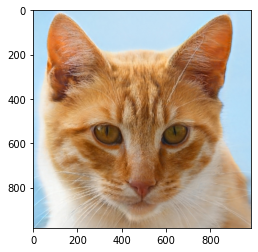

In [4]:
img_BNeck = Image.open(str('/content/sample_data/cat.jpeg'))
plt.imshow(img_BNeck)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
img_BNeck = transform(img_BNeck)
print(f"Image shape before: {img_BNeck.shape}")
img_BNeck = img_BNeck.unsqueeze(0)
print(f"Image shape after add dim: {img_BNeck.shape}")
img_BNeck = img_BNeck.to(device)


In [5]:
invertedresidual = InvertedResidual(3,6)
invertedresidual

InvertedResidual(
  (0): Sequential(
    (0): ResidualAdd(
      (block): Sequential(
        (0): ConvNormAct(
          (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): ConvNormAct(
          (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): ConvNormAct(
          (0): Conv2d(12, 6, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
      (shortcut): ConvNormAct(
        (0): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ReLU()
 

In [6]:
invertedresidual.to(device)
invertedresidual(img_BNeck).shape

torch.Size([1, 6, 224, 224])

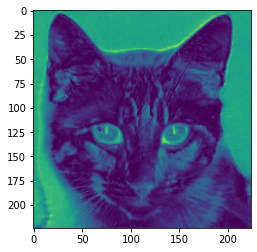

In [7]:
ir = invertedresidual(img_BNeck)
shortcut_image = ir.squeeze(0)
shortcut_image.shape 
shortcut_image  = torch.sum(shortcut_image/6,0)# decrease by sum dim
shortcut_image  = shortcut_image.data.cpu().numpy()
shortcut_image.shape #---> (224, 224)
plt.imshow(shortcut_image)


In the following class **MobileNetLikeBlock**, if only the input and output are not the same, the residual_block is used

In [8]:
class ResidualAdd(nn.Module):
    def __init__(self, block: nn.Module, shortcut: Optional[nn.Module] = None):
        super().__init__()
        self.block = block
        self.shortcut = shortcut
        
    def forward(self,x):
        res = x
        x = self.block(x)
        if self.shortcut:
            res = self.shortcut(res)
        x += res
        return x
class MobileNetLikeBlock(nn.Sequential):
    def __init__(self, in_features: int, out_features: int, expansion: int = 4):
        # use ResidualAdd if features match, otherwise a normal Sequential
        residual = ResidualAdd if in_features == out_features else nn.Sequential
        expanded_features = in_features * expansion
        super().__init__(
            nn.Sequential(
                residual(
                    nn.Sequential(
                        # narrow -> wide
                        Conv1X1BnReLU(in_features, expanded_features),
                        # wide -> wide
                        Conv3X3BnReLU(expanded_features, expanded_features),
                        # wide -> narrow
                        Conv1X1BnReLU(expanded_features, out_features, act=nn.Identity),
                    ),
                ),
                nn.ReLU(),
            )
        )
      

In [9]:
# import torch

# x = torch.randn((1, 32, 56, 56))

# Conv1X1BnReLU(32, 64)(x).shape

In [10]:
MLB=MobileNetLikeBlock(3, 6)
MLB.to(device)
MLB
# MLB(img_BNeck).shape
# MobileNetLikeBlock(32, 32)(x).shape  

MobileNetLikeBlock(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): ConvNormAct(
          (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): ConvNormAct(
          (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): ConvNormAct(
          (0): Conv2d(12, 6, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (1): ReLU()
  )
)

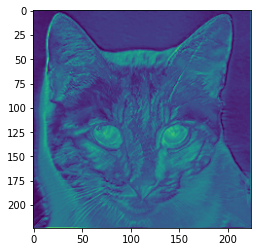

In [11]:
MLB = MLB(img_BNeck)
shortcut_image = MLB.squeeze(0)
shortcut_image.shape 
shortcut_image  = torch.sum(shortcut_image/6,0)# decrease by sum dim
shortcut_image  = shortcut_image.data.cpu().numpy()
shortcut_image.shape #---> (224, 224)
plt.imshow(shortcut_image)

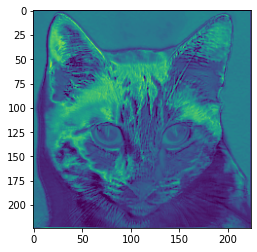

In [12]:
MLB1=MobileNetLikeBlock(3, 3)
MLB1
MLB1.to(device)
MLB1 = MLB1(img_BNeck)
shortcut_image = MLB1.squeeze(0)
shortcut_image.shape 
shortcut_image  = torch.sum(shortcut_image/3,0)# decrease by sum dim
shortcut_image  = shortcut_image.data.cpu().numpy()
shortcut_image.shape #---> (224, 224)
plt.imshow(shortcut_image)